In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np
import itertools
from itertools import permutations, combinations
import time
from pylab import *

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# ----- Step 1: Set Hyper Parameters ----- #

NAME = 'LSTM-MNIST'
OUTPUT_CLASS = 10

RELEASE_LISTS = [
    [0,1],
    [1,0]
]
RELEASE_FACTOR = 0.1

LR = 0.01
BATCH_SIZE = 32

TIME_STEP = 28
INPUT_SIZE = 28
OUTPUT_SIZE = 10

TURNS = 150

K = 3
T = 20

K_release = K-1
T_max = T-1


# ----- Step 2: Load MNIST Dataset and Create Loader ----- #

train_data = dsets.MNIST(root='../Datasets', train=True, transform=transforms.ToTensor(), download=True)
test_data = dsets.MNIST(root='../Datasets', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_X = train_data.train_data.type(torch.FloatTensor)/255.
train_Y = train_data.train_labels.numpy()
test_X = test_data.test_data.type(torch.FloatTensor)/255.
test_Y = test_data.test_labels.numpy()

train_Y1 = train_data.train_labels.type(torch.LongTensor)

y_train_onehot = torch.nn.functional.one_hot(train_Y1)


# ----- Step 3: Create Model Class ----- #

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=32,
            num_layers=1,
            batch_first=True
        )
        self.out = nn.Linear(32, OUTPUT_SIZE)

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])        # choose r_out at the last time step
        return out
    
    
# ----- Step 4: Instantiate ----- #

model = RNN()
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MS_loss_fn = torch.nn.MSELoss()


# ----- Step 5: Model Training ----- #

turns_record = []
loss_record = []
MS_loss_record = []
train_acc_record = []
F1_record = []
MCC_record = []
Score_record = []

total_loss_time = 0
total_MS_loss_time = 0
total_acc_time = 0
total_F1_time = 0
total_MCC_time = 0
total_Score_time = 0          

turns_index = 0
for turns in range(1, 151):
    if turns_index > 150:
        break
        
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.view(-1, TIME_STEP, INPUT_SIZE)
        output = model(train_x)
        loss = loss_fn(output, train_y)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()        # backward and compute gradients
        optimizer.step()       # apply gradients
        
        if batch_idx % 15 == 0:
            turns_index += 1
            if turns_index > 150:
                break

            # Shared Part - train_output
            SP_trainout_time_part_start = time.time()
            train_output = model(train_X)
            SP_trainout_time_part_stop = time.time()

            # Shared Part - softmax
            SP_softmax_time_part_start = time.time()
            train_output_result = F.softmax(train_output, dim=1)  # softmax in last dim
            SP_softmax_time_part_stop = time.time()

            # Shared Part - pred_train_y
            SP_predy_time_part_start = time.time()
            pred_train_y = torch.max(train_output, 1)[1].data.numpy()
            SP_predy_time_part_stop = time.time()

            # Acc
            acc_time_part_start = time.time()
            train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
            acc_time_part_stop = time.time()

            # MS Loss
            MS_loss_time_part_start = time.time()
            MS_train_loss = MS_loss_fn(train_output_result, y_train_onehot)
            MS_loss_time_part_stop = time.time()

            # CE Loss
            loss_time_part_start = time.time()
            train_loss = loss_fn(train_output, train_Y1)
            loss_time_part_stop = time.time()

            # F1
            F1_time_part_start = time.time()
            F1 = f1_score(train_Y, pred_train_y, average='macro')
            F1_time_part_stop = time.time()

            # MCC
            MCC_time_part_start = time.time()
            MCC = matthews_corrcoef(train_Y, pred_train_y)
            MCC_time_part_stop = time.time()

            # Score
            Score_time_part_start = time.time()
            output_results = train_output_result.detach().numpy()
            prediction_pattern = np.argsort(-output_results)[:, :K]  # sorted_states_index
            confidence_pattern = T_max - np.floor((-np.sort(-output_results)[:, :K]) * T)  # sorted_states_t
            confidence_pattern[confidence_pattern == -1] = 0

            total_score = 0
            pattern_num = len(confidence_pattern)
            release_factors = np.ones((pattern_num, K))

            for i in range(pattern_num):
                current_prediction_pattern = list(prediction_pattern[i])
                if train_Y[i] in current_prediction_pattern:
                    correct_index = current_prediction_pattern.index(train_Y[i])
                    confidence_pattern[i][correct_index] = T_max - confidence_pattern[i][correct_index]
                    release_factors[i][correct_index] = K_release

                    for release_list in RELEASE_LISTS:
                        if current_prediction_pattern[correct_index] == release_list[0]:
                            for j in range(K):
                                if j != correct_index and current_prediction_pattern[j] in release_list[1:]:
                                    release_factors[i][j] = RELEASE_FACTOR

            release_factors /= release_factors.sum(axis=1).reshape(-1,1)
            confidence_pattern[confidence_pattern == 0] = 1e-7
            confidence_pattern = -np.log(confidence_pattern / T_max)
            total_score = (np.multiply(release_factors, confidence_pattern).sum()) / pattern_num
            Score_time_part_stop = time.time()

            # (Test Acc)
            test_output = model(test_X)
            pred_test_y = torch.max(test_output, 1)[1].data.numpy()
            test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)

            print('TURNS ID: ', turns_index, '| Acc: %.4f' % train_accuracy, '| F1: %.4f' % F1, '| MCC: %.4f' % MCC, 
                  '| MS Loss: %.4f' % MS_train_loss.data.numpy(), '| CE Loss: %.4f' % train_loss.data.numpy(), 
                  '| Score: %.4f' % total_score, '| Test: %.4f' % test_accuracy)

            turns_record.append(turns_index)
            loss_record.append(train_loss.data.numpy())
            MS_loss_record.append(MS_train_loss.data.numpy())
            train_acc_record.append(train_accuracy)
            F1_record.append(F1)
            MCC_record.append(MCC)
            Score_record.append(total_score)

            SP_softmax_time = (SP_softmax_time_part_stop - SP_softmax_time_part_start)
            SP_predy_time = (SP_predy_time_part_stop - SP_predy_time_part_start)
            SP_trainout_time = (SP_trainout_time_part_stop - SP_trainout_time_part_start)

            total_loss_time += ((loss_time_part_stop - loss_time_part_start) + SP_trainout_time)
            total_MS_loss_time += ((MS_loss_time_part_stop - MS_loss_time_part_start) + SP_trainout_time + SP_softmax_time)
            total_acc_time += ((acc_time_part_stop - acc_time_part_start) + SP_predy_time + SP_trainout_time)
            total_F1_time += ((F1_time_part_stop - F1_time_part_start) + SP_predy_time + SP_trainout_time)
            total_MCC_time += ((MCC_time_part_stop - MCC_time_part_start) + SP_predy_time + SP_trainout_time)
            total_Score_time += ((Score_time_part_stop - Score_time_part_start) + SP_softmax_time + SP_trainout_time)

print('\nAverage Time Cost: ', '\nAcc: %.8f' % (total_acc_time/TURNS), '\nF1: %.8f' % (total_F1_time/TURNS), 
      '\nMCC: %.8f' % (total_MCC_time/TURNS), '\nMS Loss: %.8f' % (total_MS_loss_time/TURNS), 
      '\nCE Loss: %.8f' % (total_loss_time/TURNS), '\nScore: %.8f' % (total_Score_time/TURNS))      


C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


RNN(
  (rnn): LSTM(28, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=10, bias=True)
)
TURNS ID:  1 | Acc: 0.1124 | F1: 0.0203 | MCC: 0.0010 | MS Loss: 0.0901 | CE Loss: 2.3070 | Score: 0.4438 | Test: 0.1135
TURNS ID:  2 | Acc: 0.2680 | F1: 0.1650 | MCC: 0.2038 | MS Loss: 0.0871 | CE Loss: 2.1642 | Score: 0.7504 | Test: 0.2760
TURNS ID:  3 | Acc: 0.4166 | F1: 0.3317 | MCC: 0.3669 | MS Loss: 0.0724 | CE Loss: 1.6710 | Score: 0.6531 | Test: 0.4118
TURNS ID:  4 | Acc: 0.5176 | F1: 0.4584 | MCC: 0.4711 | MS Loss: 0.0633 | CE Loss: 1.4174 | Score: 0.6389 | Test: 0.5160
TURNS ID:  5 | Acc: 0.5319 | F1: 0.5015 | MCC: 0.4861 | MS Loss: 0.0607 | CE Loss: 1.3076 | Score: 0.6158 | Test: 0.5254
TURNS ID:  6 | Acc: 0.5812 | F1: 0.5395 | MCC: 0.5410 | MS Loss: 0.0532 | CE Loss: 1.1479 | Score: 0.5357 | Test: 0.5839
TURNS ID:  7 | Acc: 0.6336 | F1: 0.6159 | MCC: 0.5972 | MS Loss: 0.0482 | CE Loss: 1.0184 | Score: 0.5155 | Test: 0.6324
TURNS ID:  8 | Acc: 0.6450 | F1: 0.6232 | MCC:

TURNS ID:  68 | Acc: 0.9331 | F1: 0.9322 | MCC: 0.9257 | MS Loss: 0.0102 | CE Loss: 0.2321 | Score: 0.2415 | Test: 0.9343
TURNS ID:  69 | Acc: 0.9284 | F1: 0.9277 | MCC: 0.9207 | MS Loss: 0.0111 | CE Loss: 0.2477 | Score: 0.2599 | Test: 0.9292
TURNS ID:  70 | Acc: 0.9319 | F1: 0.9311 | MCC: 0.9244 | MS Loss: 0.0106 | CE Loss: 0.2376 | Score: 0.2665 | Test: 0.9334
TURNS ID:  71 | Acc: 0.9235 | F1: 0.9231 | MCC: 0.9152 | MS Loss: 0.0117 | CE Loss: 0.2637 | Score: 0.3031 | Test: 0.9196
TURNS ID:  72 | Acc: 0.9323 | F1: 0.9316 | MCC: 0.9248 | MS Loss: 0.0104 | CE Loss: 0.2352 | Score: 0.2487 | Test: 0.9331
TURNS ID:  73 | Acc: 0.9264 | F1: 0.9259 | MCC: 0.9184 | MS Loss: 0.0113 | CE Loss: 0.2552 | Score: 0.2759 | Test: 0.9242
TURNS ID:  74 | Acc: 0.8838 | F1: 0.8820 | MCC: 0.8718 | MS Loss: 0.0170 | CE Loss: 0.3746 | Score: 0.3591 | Test: 0.8846
TURNS ID:  75 | Acc: 0.9092 | F1: 0.9094 | MCC: 0.8996 | MS Loss: 0.0137 | CE Loss: 0.2992 | Score: 0.3079 | Test: 0.9117
TURNS ID:  76 | Acc: 0.9

TURNS ID:  135 | Acc: 0.9546 | F1: 0.9541 | MCC: 0.9496 | MS Loss: 0.0070 | CE Loss: 0.1638 | Score: 0.1614 | Test: 0.9559
TURNS ID:  136 | Acc: 0.9580 | F1: 0.9577 | MCC: 0.9534 | MS Loss: 0.0065 | CE Loss: 0.1456 | Score: 0.1540 | Test: 0.9597
TURNS ID:  137 | Acc: 0.9488 | F1: 0.9484 | MCC: 0.9432 | MS Loss: 0.0076 | CE Loss: 0.1657 | Score: 0.1717 | Test: 0.9501
TURNS ID:  138 | Acc: 0.9578 | F1: 0.9574 | MCC: 0.9531 | MS Loss: 0.0065 | CE Loss: 0.1454 | Score: 0.1676 | Test: 0.9576
TURNS ID:  139 | Acc: 0.9558 | F1: 0.9554 | MCC: 0.9510 | MS Loss: 0.0068 | CE Loss: 0.1494 | Score: 0.1709 | Test: 0.9548
TURNS ID:  140 | Acc: 0.9538 | F1: 0.9534 | MCC: 0.9488 | MS Loss: 0.0069 | CE Loss: 0.1502 | Score: 0.1629 | Test: 0.9551
TURNS ID:  141 | Acc: 0.9560 | F1: 0.9556 | MCC: 0.9512 | MS Loss: 0.0067 | CE Loss: 0.1477 | Score: 0.1659 | Test: 0.9574
TURNS ID:  142 | Acc: 0.9576 | F1: 0.9573 | MCC: 0.9529 | MS Loss: 0.0065 | CE Loss: 0.1465 | Score: 0.1492 | Test: 0.9602
TURNS ID:  143 |

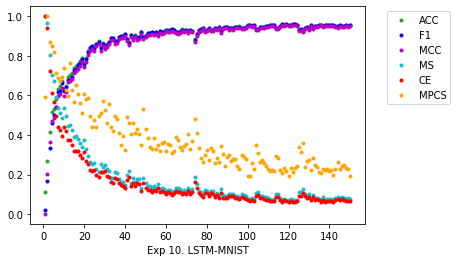

In [4]:
# loss 归一化
max_loss = 0
max_MS_loss = 0
max_train_acc = 0
max_F1 = 0
max_MCC = 0
max_Score = 0

for i in range(len(turns_record)):
    if loss_record[i] > max_loss:
        max_loss = loss_record[i]
    if MS_loss_record[i] > max_MS_loss:
        max_MS_loss = MS_loss_record[i]
    if Score_record[i] > max_Score:
        max_Score = Score_record[i]    

for i in range(len(loss_record)):
    loss_record[i] = loss_record[i]/max_loss
    MS_loss_record[i] = MS_loss_record[i]/max_MS_loss
    Score_record[i] = Score_record[i]/max_Score
    
plt.plot(turns_record, train_acc_record, '.', color = 'tab:green', label='ACC')
plt.plot(turns_record, F1_record, '.', color = 'b', label='F1') # lightpink
plt.plot(turns_record, MCC_record, '.', color = 'm', label='MCC')
plt.plot(turns_record, MS_loss_record, '.', color = 'tab:cyan', label='MS') # turquoise
plt.plot(turns_record, loss_record, '.', color = 'r', label='CE') # blueviolet
plt.plot(turns_record, Score_record, '.', color = 'orange', label='MPCS')

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

LABEL = 'Exp 10'
plt.xlabel(f"{LABEL}. {NAME}")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.savefig(f'../Savefig/{LABEL}.png', bbox_inches='tight', dpi=600)  # 保存该图片
plt.show()

In [8]:
import pandas as pd

train_acc_record_df = pd.DataFrame(train_acc_record)
F1_record_df = pd.DataFrame(F1_record)
MCC_record_df = pd.DataFrame(MCC_record)
MS_loss_record_df = pd.DataFrame(MS_loss_record)
loss_record_df = pd.DataFrame(loss_record)
Score_record_df = pd.DataFrame(Score_record)

data_df = pd.concat([train_acc_record_df, F1_record_df, MCC_record_df, MS_loss_record_df, loss_record_df, Score_record_df], axis=1)
data_df.columns = ['Accuracy', 'F1-score', 'MCC', 'Mean Squared', 'Cross Entropy', 'MPWS']  # head

writer = pd.ExcelWriter(f"../Records/{LABEL}. {NAME}.xlsx")
data_df.to_excel(writer,'page_1')
writer.save()

